In [75]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from keras import optimizers
from statistics import mean
from keras.utils import load_img, img_to_array
from keras import metrics

#import modules
import os
from keras.applications import VGG16

In [76]:
image_height = 200
image_weight = 150
sequence = 3

def arrange_data(df, map):
    image_data = []
    ids = df[df.columns[0]]
    map = f"{map}/raw_images/"
    
    df = df.drop(df.columns[0], axis=1)
    
    for i in ids:
        img = load_img(f"{map}{i}.jpg", target_size=(image_height, image_weight, sequence))
        img = img_to_array(img)
        image_data.append(img)
    
    X = np.array(image_data)
    Y = np.array(df)
    
    print("Shape of images:", X.shape)
    print("Shape of labels:", Y.shape)
    
    return X, Y

In [77]:
# splitting data and scale

current_folder = os.path.abspath('')
map = f"{current_folder}/data/"

# reads first row as header
print("Processing train..")
train_df = pd.read_csv(f"{map}train.csv", delimiter=',', header=None)
X_train, Y_train = arrange_data(train_df, current_folder)

# reads first row double
print("Processing valid..")
val_df = pd.read_csv(f"{map}valid.csv", delimiter=',', header=0)
X_val, Y_val = arrange_data(val_df, current_folder)

# scale data 
X_train = X_train / 255
X_val = X_val / 255


Processing train..
Shape of images: (614, 200, 150, 3)
Shape of labels: (614, 26)
Processing valid..
Shape of images: (236, 200, 150, 3)
Shape of labels: (236, 26)


In [78]:
#Load the VGG model
base_model = keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(image_height, image_weight, sequence)
    )

# For freezing the layer we make use of layer.trainable = False
base_model.trainable = True
#freeze first four layers
for layer in base_model.layers[:-3]:
 layer.trainable = False

model= Sequential()
model.add(base_model) #Adds the base model (in this case vgg19 to model_1)
model.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
# model.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights

model.add(Dense(128,activation=('relu')))

model.add(Dropout(.3))

model.add(Dense(26, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 4, 512)         14714688  
                                                                 
 flatten_18 (Flatten)        (None, 12288)             0         
                                                                 
 dense_66 (Dense)            (None, 1024)              12583936  
                                                                 
 dense_67 (Dense)            (None, 512)               524800    
                                                                 
 dense_68 (Dense)            (None, 256)               131328    
                                                                 
 dense_69 (Dense)            (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)             

In [79]:
version = 'v2'

opt = optimizers.SGD(
    learning_rate=0.001, 
    decay=1e-3, 
    momentum=0.9, 
    nesterov=True
    )

model.compile(
    # optimizer=opt,
    # optimizer='Adam',
    optimizer=optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy', 
    metrics=[metrics.Precision()], 
    )

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    mode='min',
    restore_best_weights=True
    )

# train the network
history = model.fit(X_train, Y_train, 
                    epochs=21, 
                    batch_size=64,
                    shuffle = True, 
                    # validation_split = 0.2,
                    validation_data=(X_val, Y_val), 
                    callbacks=[early_stopping_callback]
                    )

model.save(f'{current_folder}/model/pretrained/{version}/Model_4c_{version}.h5')

Epoch 1/21


c:\Users\cheeyau\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


10/10 [==============================] - 57s 6s/step - loss: 0.6649 - precision_8: 0.0952 - val_loss: 0.5745 - val_precision_8: 0.0984
Epoch 2/21
10/10 [==============================] - 53s 5s/step - loss: 0.5369 - precision_8: 0.1114 - val_loss: 0.4486 - val_precision_8: 0.1140
Epoch 3/21
10/10 [==============================] - 54s 6s/step - loss: 0.4542 - precision_8: 0.1226 - val_loss: 0.3619 - val_precision_8: 0.1250
Epoch 4/21
10/10 [==============================] - 54s 6s/step - loss: 0.4092 - precision_8: 0.1353 - val_loss: 0.3135 - val_precision_8: 0.0000e+00
Epoch 5/21
10/10 [==============================] - 54s 5s/step - loss: 0.3892 - precision_8: 0.1630 - val_loss: 0.2888 - val_precision_8: 0.5152
Epoch 6/21
10/10 [==============================] - 53s 5s/step - loss: 0.3801 - precision_8: 0.1705 - val_loss: 0.2776 - val_precision_8: 0.6522
Epoch 7/21
10/10 [==============================] - 53s 5s/step - loss: 0.3682 - precision_8: 0.1936 - val_loss: 0.2706 - val_preci

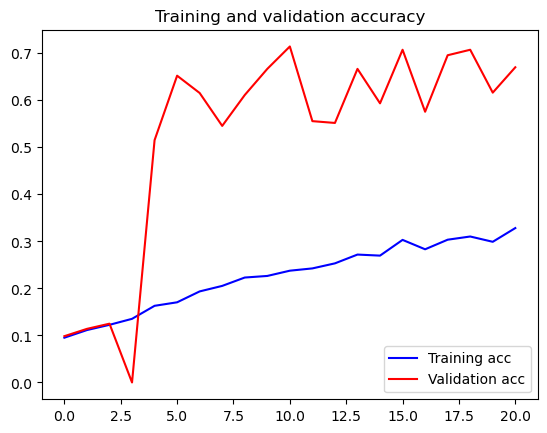

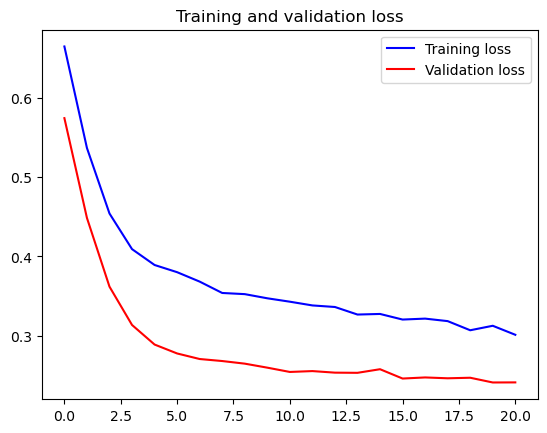

In [80]:
v = '8'

acc = history.history[f'precision_{v}']
val_acc = history.history[f'val_precision_{v}']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()